In [6]:
import os
import sys
import pandas as pd
import numpy as np
import re
import PATH
import torch
from torch import nn

from torch.utils.data import DataLoader,Dataset,random_split

from matplotlib import pyplot as plt

from models.popen import Auto_popen
from models.ScheduleOptimizer import ScheduledOptim 
from models.log_and_save import Log_parser,plot_a_exp_set
from models import reader
from models import DL_models

/home/wergillius/Project/UTR_VAE


In [7]:
from importlib import reload

In [8]:
import utils
reload(utils)
from utils import Seq_one_hot,read_UTR_csv,read_label

/home/wergillius/Project/UTR_VAE


## read A549 data

In [8]:
A549_csv = read_UTR_csv(cell_line='A549')

In [ ]:
reader.get_splited_dataloader()

In [26]:
X = Seq_one_hot().d_transform(A549_csv,flattern=False) # (3970, 100, 4)

In [47]:
mask_index = np.random.randint(0,100,(3970,10,5))

In [42]:
mask_X = X.copy()

In [43]:
zeros = np.zeros(shape=[3970, 100,1])

In [54]:
X_orin = np.concatenate([mask_X,zeros],axis=2)

In [107]:
dataset = reader.UTR_dataset(cell_line='A549')
ratio = [0.7,0.2,0.1]
total_len = len(dataset)
lengths = [int(total_len*ratio[0]),int(len(dataset)*ratio[1])]
lengths.append(total_len-sum(lengths))         # make sure the sum of length is the total len

set_ls = random_split(X_orin,lengths,generator=torch.Generator().manual_seed(42))         # split dataset 

In [108]:
train_set,val_set,test_set = set_ls

In [112]:
len(train_set),len(val_set),len(test_set)

(2779, 794, 397)

## mask and save to npy

In [111]:
train_data = []
for data_ii in range(2779):
    for repeat in range(10):
        X_5dim = X_orin[data_ii].copy()
        
        to_mask = mask_index[data_ii,repeat]
        X_5dim[to_mask,:]=0
        X_5dim[to_mask,4]=1
        
        train_data.append((X_5dim,X_orin[data_ii]))

In [123]:
train_data = np.array(train_data)

In [128]:
np.save(os.path.join(reader.data_dir,'train_mask.npy'),train_data)

In [117]:
val_data = []
for data_ii in range(2779,2779+794):
    for repeat in range(10):
        X_5dim = X_orin[data_ii].copy()
        
        to_mask = mask_index[data_ii,repeat]
        X_5dim[to_mask,:]=0
        X_5dim[to_mask,4]=1
        
        val_data.append((X_5dim,X_orin[data_ii]))

In [130]:
val_data = np.array(val_data)
np.save(os.path.join(reader.data_dir,'val_mask.npy'),val_data)

In [119]:
test_data = []
for data_ii in range(3573,3573+397):
    for repeat in range(10):
        X_5dim = X_orin[data_ii].copy()
        
        to_mask = mask_index[data_ii,repeat]
        X_5dim[to_mask,:]=0
        X_5dim[to_mask,4]=1
        
        test_data.append((X_5dim,X_orin[data_ii]))

In [129]:
test_data = np.array(test_data)
np.save(os.path.join(reader.data_dir,'test_mask.npy'),test_data)

## make a new data reader

In [5]:
train_set1 = np.load(os.path.join(reader.data_dir,'train_mask.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/users/wergillius/UTR_VAE/data/train_mask.npy'

In [135]:
X = train_set1[:,0]
Y = train_set1[:,1]

In [137]:
Y.shape

(27790, 100, 5)

In [134]:
train_set1.dtype

dtype('float64')

In [142]:
mask_train_set = mask_reader(os.path.join(reader.data_dir,'train_mask.npy'))

In [145]:
train_loader = DataLoader(mask_train_set,batch_size=10)

In [148]:
loader=iter(train_loader)

In [149]:
X,Y=next(loader)

In [166]:
train_loader,val_loader,test_loader = reader.get_mask_dataloader(10,4)

In [167]:
train_iter = iter(train_loader)

In [169]:
X,Y = next(train_iter)

## Ex data

In [9]:
from models import reader

In [10]:
data_dir = "/data/users/wergillius/UTR_VAE/Ex_data"

In [11]:
file=os.listdir(data_dir)
file

['GSM3130443_designed_library.csv',
 'GSM3130435_egfp_unmod_1.csv',
 'GSM3130438_egfp_pseudo_2.csv',
 'GSM3130441_mcherry_1.csv',
 'GSM3130439_egfp_m1pseudo_1.csv',
 'GSM3130442_mcherry_2.csv',
 'GSM3130437_egfp_pseudo_1.csv',
 'GSM4084997_varying_length_25to100.csv',
 'GSM3130436_egfp_unmod_2.csv',
 'GSM3130440_egfp_m1pseudo_2.csv']

In [19]:
vleng_df = pd.read_csv(os.path.join(data_dir,file[0]))
vleng_df.shape

/home/wergillius/.conda/envs/pytorch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33,34,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(100017, 42)

In [20]:
vleng_df.columns

Index(['Unnamed: 0', 'utr', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', 'total', 'r0', 'r1', 'r2', 'r3', 'r4', 'r5',
       'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r_total', 'rl',
       'id', 'info1', 'info2', 'info3', 'info4', 'library', 'mother',
       'designed', 'match_score'],
      dtype='object')

In [21]:
vleng_df.rl.values

array([4.82308169, 6.25220814, 7.49957397, ..., 2.33541198, 7.1217235 ,
       5.69451145])

In [41]:
ex_sequence = vleng_df[(vleng_df.library == 'human_utrs')|(vleng_df.library == 'snv')].loc[:,['utr','rl','r_total','match_score','library']]

In [234]:
# discretize the data into 50 nt
ex_sequence = np.array([list(seq) for seq in ex_sequence])
ex_sequence.shape
# one hot
short_oh = Seq_one_hot(seq_len = 50)
ex_oh = short_oh.transform(ex_sequence,False)

## mask and padding to 100

In [289]:
n = ex_oh.shape[0]
padding_25 = np.zeros((n,25,5))
zeros_side = np.zeros((n,50,1))

# make one hot sequence to 5 dimension
ex_orin = np.concatenate([ex_oh,zeros_side],axis=2)
ex_5dim_long = np.concatenate([padding_25,ex_orin,padding_25],axis=1)
ex_5dim_long.shape

(23552, 100, 5)

In [290]:
ratio = [0.7,0.2,0.1]
lengths = [int(n*ratio[0]),int(n*ratio[1])]
lengths.append(n-sum(lengths))
train,val,test=random_split(ex_5dim_long,lengths=lengths,generator=torch.Generator().manual_seed(42))

In [291]:
lengths

[16486, 4710, 2356]

In [322]:
mask_index = np.random.randint(25,75,(n,4,4))

In [323]:
def mask_sequence(dataset,mask_index=mask_index):
    final = []
    for seq in range(len(dataset)):
        final.append((dataset[seq],dataset[seq]))
        for n in range(mask_index.shape[1]):
            sequence = dataset[seq].copy()
            sequence[mask_index[seq,n],:]=0
            sequence[mask_index[seq,n],4]=1
            final.append((sequence,dataset[seq]))
    
    final = np.array(final)
    print(final.shape)
    return final

In [333]:
ex_train_masked = mask_sequence(train)
ex_val_masked = mask_sequence(val)
ex_test_masked = mask_sequence(test)

(82430, 2, 100, 5)
(23550, 2, 100, 5)
(11780, 2, 100, 5)


mix with our data and save 

In [343]:
mix_train = np.concatenate([train_data,ex_train_masked],axis=0)
mix_val = np.concatenate([val_data,ex_val_masked],axis=0)
mix_test = np.concatenate([test_data,ex_test_masked],axis=0)

print(mix_train.shape)
print(mix_val.shape)
print(mix_test.shape)

np.save(os.path.join(utils.data_dir,'mix_data','mix_train.npy'),mix_train)
np.save(os.path.join(utils.data_dir,'mix_data','mix_val.npy'),mix_val)
np.save(os.path.join(utils.data_dir,'mix_data','mix_test.npy'),mix_test)

check sequence

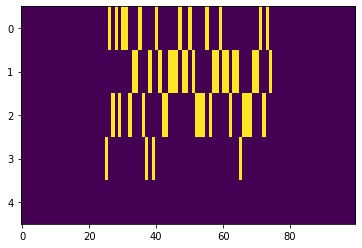

In [334]:
plt.imshow(ex_train_masked[5,0].T,aspect='auto');